In [75]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
import itertools

pio.renderers.default = "iframe"

In [2]:
def read_config(path: Path) -> Dict:
    with path.open("r") as config_file:
        config = yaml.safe_load(config_file)
    return config


def read_configs(base_path: str, spark_session: SparkSession) -> pyspark.RDD:
    completed_filenames = list(Path(base_path).glob("*/completed.txt"))
    configs = map(lambda x: x.parent / "config.yaml", completed_filenames)
    configs = map(read_config, configs)
    return spark_session.sparkContext.parallelize(configs)


def create_configs_df(configs: pyspark.RDD) -> DataFrame:
    config_columns = [
        "simulation_id",
        "slope",
        "r_stat_multiplier",
        "effective_radius_multiplier",
        "min_rim_percentage"
    ]
    return configs.map(lambda x: {k: v for k, v in x.items() if k in config_columns}).toDF().cache()

In [79]:
def get_state_at_time(stats_df: DataFrame,
                      craters_df: DataFrame,
                      removals_df: DataFrame,
                      simulation_id: int,
                      target_n_craters_added_in_study_region: int,
                      study_region_size: int,
                      study_region_padding: int) -> pd.DataFrame:
    max_crater_id = stats_df.where(
        (F.col("simulation_id") == F.lit(simulation_id))
        & (F.col("n_craters_added_in_study_region") <= F.lit(target_n_craters_added_in_study_region))
    ).select(F.max("crater_id")).collect()[0][0]
    
    stats_df.createOrReplaceTempView("stats")
    craters_df.createOrReplaceTempView("craters")
    removals_df.createOrReplaceTempView("removals")

    query = f"""
    SELECT
        c.x,
        c.y,
        c.radius
    FROM
        craters c
        LEFT JOIN removals r ON
            r.simulation_id = c.simulation_id
            AND r.removed_crater_id = c.id
    WHERE
        c.simulation_id == {simulation_id}
        AND c.id <= {max_crater_id}
        AND (r.removed_by_crater_id IS NULL OR r.removed_by_crater_id > {max_crater_id})
        AND c.x >= {study_region_padding} AND c.x < {study_region_padding + study_region_size}
        AND c.y >= {study_region_padding} AND c.y < {study_region_padding + study_region_size}
    """
    return spark.sql(query).toPandas()

In [531]:
def calculate_areal_density(craters: pd.DataFrame,
                            study_region_size: float,
                            study_region_padding: float,
                            r_stat: float) -> float:
    from saturation.areal_density import ArealDensityCalculator
    from saturation.datatypes import Crater

    ad_calculator = ArealDensityCalculator(
        (study_region_size, study_region_size),
        (study_region_padding, study_region_padding),
        r_stat)
    for idx, row in craters.iterrows():
        ad_calculator.add_crater(
            Crater(
                idx,
                row.x,
                row.y,
                row.radius
            )
        )

    return ad_calculator.areal_density

In [73]:
def plot_circle(center: Tuple[float, float],
                radius: float,
                axes_subplot,
                fill: bool = False,
                color: str = 'black',
                lw: float = 1,
                antialiased: bool = True):
    """
    Plots the specified circle on the supplied subplot.
    """
    axes_subplot.add_patch(matplotlib.patches.Circle(center,
                                                     radius=radius,
                                                     color=color,
                                                     fill=fill,
                                                     lw=lw,
                                                     antialiased=antialiased))

def plot_terrain(data: pd.DataFrame):
    x_range = data.x.max() - data.x.min()
    y_range = data.y.max() - data.y.min()
    xy_range = max(x_range, y_range)
    
    figsize = 5
    fig, ax = plt.subplots(figsize=(figsize * x_range / xy_range, figsize * y_range / xy_range))

    # x, y are in km, radius is in m, let's make them consistent
    data = data.copy()

    # ax.set_xlim([data.x.min() - 15, data.x.min() + xy_range + 15])
    # ax.set_ylim([data.y.min() - 15, data.y.min() + xy_range + 15])

    ax.set_xlim([data.x.min() - 15, data.x.max() + 15])
    ax.set_ylim([data.y.min() - 15, data.y.max() + 15])
    
    # Plot craters
    for idx, row in data.iterrows():
        plot_circle((row.x, row.y), row.radius, ax)

    plt.show()

In [3]:
n_cores = 26

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/01/06 13:22:08 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
24/01/06 13:22:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/06 13:22:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
base_path = "/data/saturation/n_craters_stop_condition_20230918"

In [97]:
r_stat = 5
study_region_size = 4000
study_region_padding = int(study_region_width * 0.125)

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pd = configs_df.toPandas()

In [506]:
configs_pd.sort_values("slope")

,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,simulation_id,slope
1837,1.557037,0.578610,7.179055,5574,1.000033
9362,1.684887,0.254751,7.074474,1855,1.000542
2106,1.466980,0.405691,5.364887,1454,1.000595
2439,1.155418,0.665938,6.574527,2339,1.000720
5197,1.670259,0.300565,6.732916,5405,1.000771
...,...,...,...,...,...
3758,1.528206,0.264667,7.925539,5537,2.998700
2133,1.725425,0.327028,3.222247,2391,2.998727
7563,1.470274,0.287845,7.494870,1923,2.998850
3928,1.751865,0.589493,8.373902,8296,2.999581


In [507]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 8296
target_n_craters_added_in_study_region = 1000

state_8296_1000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [706]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 8296
target_n_craters_added_in_study_region = 500

state_8296_500 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [586]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 8296
target_n_craters_added_in_study_region = 360000

state_8296_360000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [508]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 8296
target_n_craters_added_in_study_region = 100000

state_8296_100000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [480]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 7099
target_n_craters_added_in_study_region = 1000

state_7099_1000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [481]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 4458
target_n_craters_added_in_study_region = 1000

state_4458_1000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [482]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 7230
target_n_craters_added_in_study_region = 1000

state_7230_1000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [483]:
stats_df = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals_df = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

simulation_id = 7230
target_n_craters_added_in_study_region = 100000

state_7230_100000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

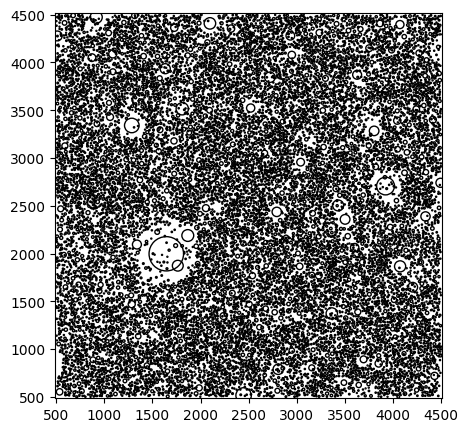

In [520]:
plot_terrain(state_8296_100000)

In [536]:
calculate_areal_density(state_8296_1000, study_region_size, study_region_padding, r_stat)

0.0147891875

In [766]:
stats_df = spark.read.parquet(f"/data/saturation/deep_test/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"/data/saturation/deep_test/*/craters_*.parquet")
removals_df = spark.read.parquet(f"/data/saturation/deep_test/*/crater_removals_*.parquet")

simulation_id = 3
target_n_craters_added_in_study_region = 3000000

state_3_3000000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [797]:
stats_df = spark.read.parquet(f"/data/saturation/deep_test/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"/data/saturation/deep_test/*/craters_*.parquet")
removals_df = spark.read.parquet(f"/data/saturation/deep_test/*/crater_removals_*.parquet")

simulation_id = 2
target_n_craters_added_in_study_region = 3000000

state_2_3000000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [828]:
stats_df = spark.read.parquet(f"/data/saturation/deep_test/*/statistics_*.parquet")
craters_df = spark.read.parquet(f"/data/saturation/deep_test/*/craters_*.parquet")
removals_df = spark.read.parquet(f"/data/saturation/deep_test/*/crater_removals_*.parquet")

simulation_id = 1
target_n_craters_added_in_study_region = 3000000

state_1_3000000 = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding
)   

In [852]:
state = state_1_3000000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

(-3.0925, 0.03330125143203009)

In [853]:
state = state_2_3000000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

(-4.1713, 0.036612807675346)

In [864]:
state = state_3_3000000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

(-5.1487, 0.04167470095278495)

In [855]:
state = state_8296_500
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

(-2.9608, 0.13693745540947092)

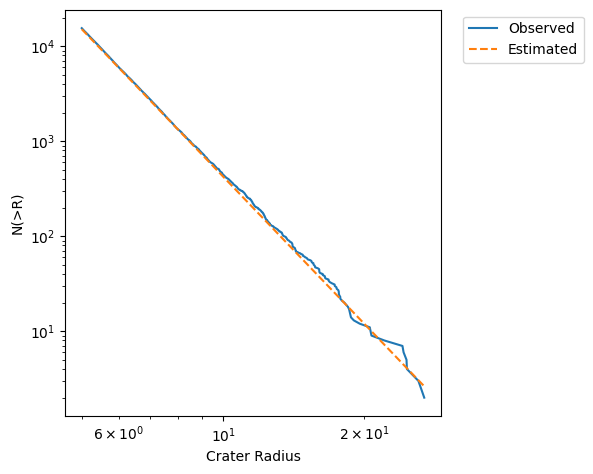

In [869]:
slope = 5.15
plot_sfds(state_3_3000000, slope, intercept=6e7)

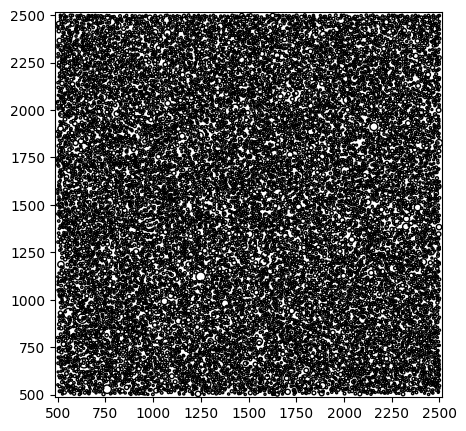

In [870]:
plot_terrain(state_3_3000000)

In [888]:
craters_arrays = []
for x in range(100000, 3000001, 100000):
    c = pd.read_parquet(f"/data/saturation/deep_test/deep_5.0/craters_{x}.parquet")
    c = c[(c.index % 10) == 9]
    craters_arrays.append(c)    

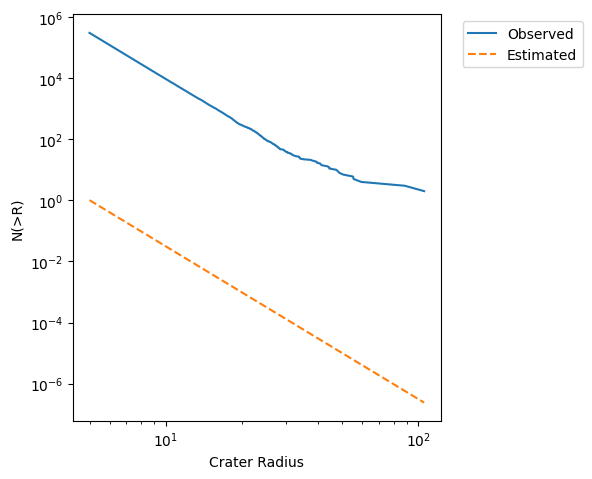

In [899]:
c = pd.concat(craters_arrays)
slope = 5
plot_sfds(c, slope, intercept=3162)

In [893]:
state = c
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.quantile(0.9) * 2,
                          min_search_slope=0.0,
                          max_search_slope=10.0)

(-5.0569, 0.08893482819263718)

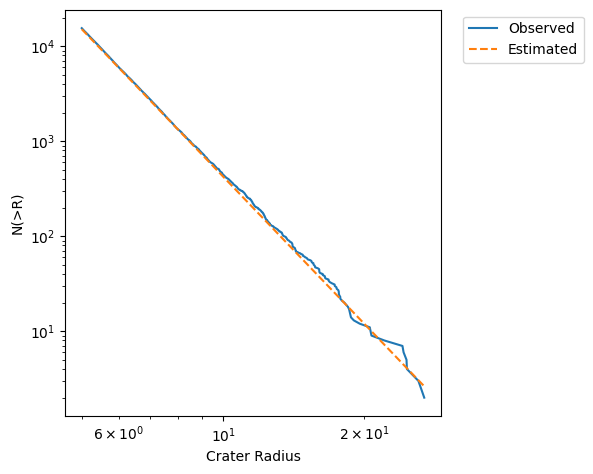

In [882]:
slope = 5.15
plot_sfds(state_3_3000000, slope, intercept=6e7)

### Fitting CSFD slopes

In [487]:
craters_df = pd.read_csv("data/Dione_reg1-all.csv") # DEE, slope -2.10 +/- 0.08
# craters_df = pd.read_csv("data/Dione_reg2-all.csv") # DSP, slope -2.66 +/- 0.05
# craters_df = pd.read_csv("data/Dione_reg3-all.csv") # DICP, slope -2.08 +/- 0.09
# craters_df = pd.read_csv("data/Dione_reg4-all.csv") # DDCP, slope -2.15 +/- 0.05
craters_df.describe()

,longitude,latitude,Diameter:double
count,145.000000,145.000000,145.000000
mean,233.080306,-40.181611,7403.295204
std,22.943033,12.143859,4130.081336
min,188.230000,-67.980000,4005.566724
25%,210.560000,-48.600000,4696.474094
50%,233.320010,-41.160000,5589.926057
75%,249.509990,-29.800000,8517.185632
max,280.790010,-18.700000,26759.259730


In [847]:
def estimate_cumulative_slope(diameters: List[float],
                              min_diameter: float,
                              max_diameter: float,
                              min_search_slope: float = 0.0,
                              max_search_slope: float = 10.0) -> float:
    N_GUESSES = 100000

    # Filter craters to only those between min and max
    diameters = np.array([x for x in diameters if min_diameter <= x <= max_diameter])

    summation = np.sum(np.log(diameters / min_diameter))
    n_craters = diameters.shape[0]

    guesses = min_search_slope + np.array([x * (max_search_slope - min_search_slope) / N_GUESSES for x in range(1, N_GUESSES + 1)])

    min_max_ratio = min_diameter / max_diameter
    guesses = n_craters / guesses + n_craters * min_max_ratio**guesses * np.log(min_max_ratio) / (1 - min_max_ratio**guesses) - summation
    
    min_index = np.argmin(np.abs(guesses))
    alpha = min_search_slope + min_index * (max_search_slope - min_search_slope) / N_GUESSES
    cumulative_slope = -alpha
    
    sigma = min_max_ratio**alpha * np.log(min_max_ratio)**2 / (1 - min_max_ratio**alpha)**2
    sigma = np.sqrt(1 / (1 / alpha**2 - sigma) / n_craters)
    
    return cumulative_slope, sigma

In [822]:
state = state_4458_1000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.max() * 2)

24550


(-1.2275, 0.0500059522557295)

In [823]:
state = state_8296_1000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.quantile(0.5) * 2)

25447


(-1.27235, 0.6581499169217484)

In [794]:
state = state_8296_100000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.quantile(0.95) * 2)

(-3.195, 0.03420772828726251)

In [795]:
state = state_8296_360000
estimate_cumulative_slope(state.radius * 2,
                          state.radius.min() * 2,
                          state.radius.quantile(0.75) * 2)

(-3.145, 0.07120086884279807)

In [868]:
def plot_sfds(data: pd.DataFrame, slope: float, intercept: float = 1):
    radii = data.radius.sort_values()
    
    # Track min and max radii
    min_radius = radii.min()
    max_radius = radii.max()
          
    plt.plot(radii, range(len(radii) + 1, 1, -1), label="Observed")
    plt.xlabel("Crater Radius")
    plt.ylabel("N(>R)")

    expected = intercept * radii ** -slope
    plt.plot(radii, expected, label="Estimated", ls="--")

    plt.subplots_adjust(right=0.7)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

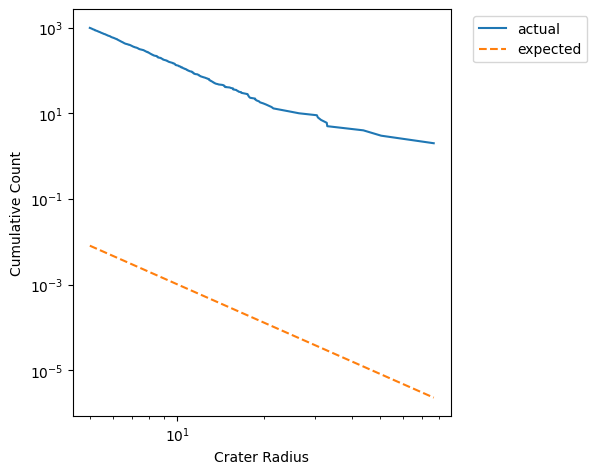

In [818]:
slope = 2.99
plot_sfds(state_8296_1000, slope)

In [714]:
slope = 2.99
radii = state_8296_360000.radius.sort_values(ascending=True)
expected = 0.05 * radii ** -slope
expected

15204    4.064806e-04
6155     4.064801e-04
5351     4.064777e-04
10751    4.064617e-04
2145     4.064586e-04
             ...     
5944     1.129357e-07
13785    1.121157e-07
4399     9.365220e-08
5698     9.195161e-08
8827     5.018452e-08
Name: radius, Length: 17613, dtype: float32

In [708]:
from scipy.optimize import curve_fit

In [976]:
craters = c.sort_values("radius").reset_index()
slope = 5.
def func(input, const):
    return const * np.power(input, -4.98)


# coeff2, cov2 = curve_fit(func2,
#                          prime_diam_range[index_prime_diam_slope_min[0, 0]:index_max],
#                          kde[index_prime_diam_slope_min[0, 0]:index_max, 0] / area,
#                          p0=0.05)
coeff, cov = curve_fit(func,
                         craters.radius,
                         np.array(range(len(craters.radius), 0, -1)).astype("float"),
                         p0=10000000000.)
coeff, cov

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning:

Covariance of the parameters could not be estimated



(array([1.e+10]), array([[inf]]))

In [974]:
func(craters.radius, 1e9)

0         319999.687500
1         319999.250000
2         319998.156250
3         319998.156250
4         319998.000000
              ...      
299995         1.952879
299996         1.898027
299997         1.338208
299998         0.184514
299999         0.076403
Name: radius, Length: 300000, dtype: float32

In [971]:
len(craters.radius)

300000

In [947]:
def func(x, c):
    return c * np.power(x, -5.0)

indep = np.array([float(x + 1) for x in range(10000)])
dep = indep ** -5.0 * 123.123
coeff, cov = curve_fit(func, indep, dep)
coeff

array([123.123])

In [928]:
dep

array([           inf, 5.00000000e+00, 1.56250000e-01, ...,
       5.00750675e-20, 5.00500300e-20, 5.00250075e-20])

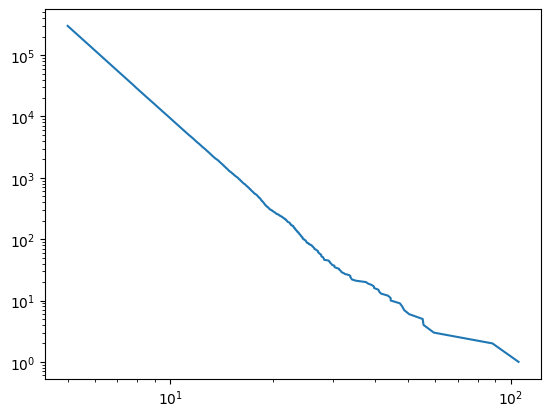

In [955]:
plt.plot(
    craters.radius,
    np.array(range(len(craters.radius), 0, -1)).astype("float"),
)
plt.xscale('log')
plt.yscale('log')

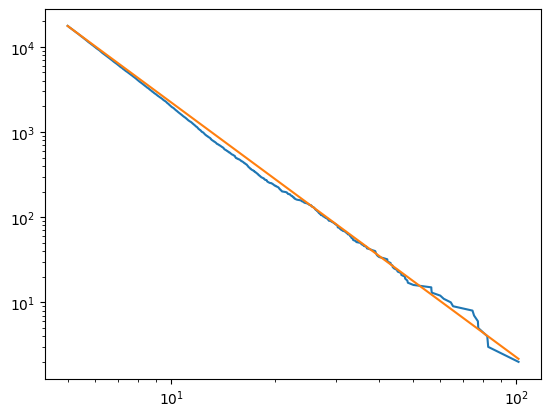

In [765]:
plt.plot(
    radii,
    np.array(range(len(radii) + 1, 1, -1))
)
plt.plot(
    radii,
    2162000.2777 * radii ** (-slope)
)
plt.xscale('log')
plt.yscale('log')

In [663]:
(len(state_8296_360000.radius) * state_8296_360000.radius ** -slope).describe()

count    17613.000000
mean        73.246185
std         40.864006
min          0.017678
25%         37.980850
50%         73.897682
75%        108.561340
max        143.186844
Name: radius, dtype: float64

In [664]:
state_8296_360000.radius.describe()

count    17613.000000
mean         7.347311
std          3.842476
min          5.000038
25%          5.485085
50%          6.238081
75%          7.793430
max        101.427078
Name: radius, dtype: float64

In [575]:
radii = state_8296_250000.radius.sort_values(ascending=False)
min_radius = radii.min()
max_radius = radii.max()

expected = np.array([slope * min_radius **slope / x ** (slope + 1) for x in radii]) * (max_radius - min_radius) + min_radius

In [585]:
state_8296_250000.shape

(17613, 3)

In [541]:
craters_df = pd.read_csv("data/Dione_reg1-all.csv") # DEE, slope -2.10 +/- 0.08
diameters = craters_df["Diameter:double"]
estimate_cumulative_slope(diameters,
                          diameters.min(),
                          diameters.max())

(-1.725, 0.19107113166310233)

In [542]:
craters_df = pd.read_csv("data/Dione_reg2-all.csv") # DSP, slope -2.66 +/- 0.05
diameters = craters_df["Diameter:double"]
estimate_cumulative_slope(diameters,
                          diameters.min(),
                          diameters.max())

(-2.355, 0.1561049407109661)

In [543]:
craters_df = pd.read_csv("data/Dione_reg3-all.csv") # DICP, slope -2.08 +/- 0.09
diameters = craters_df["Diameter:double"]
estimate_cumulative_slope(diameters,
                          diameters.min(),
                          diameters.max())

(-0.55, 0.05546174495164724)

In [544]:
craters_df = pd.read_csv("data/Dione_reg4-all.csv") # DDCP, slope -2.15 +/- 0.05
diameters = craters_df["Diameter:double"]
estimate_cumulative_slope(diameters,
                          diameters.min(),
                          diameters.max())

(-1.94, 0.10689581317554972)